<h1>Analysis of Online Body Transformations</h1>

Zachary Wynegar and Joshua Karper<br />
University of Maryland, College Park<br />

__[Reddit](https://www.reddit.com)__
is an online forum where users are able to create posts on a digital messageboard. A portion of the website is dedicated to body progress transformation pictures where users create a title describing their body transformation, then upload photos of themselves before and after their body transformation. This tutorial performs an analysis of these postings including scraping the data from the reddit servers, storing large amounts of post data, parsing user-created threads to extract usable data, and analyzing result data. By the end of this tutorial you should know (1) how to scrape data from reddit servers, (2) how to parse body transformation 1-line summaries for usable data, (3) how to clean that data, (4) be able to see some neat trends, (5) and even some classification.
<br /><br />

In particular, we're going to be scraping and looking at data from two different subreddits - __[/r/progresspics](https://www.reddit.com/r/progresspics)__ & __[/r/brogress](https://www.reddit.com/r//r/brogress)__. As we'll find out, both subreddits are based around body transformations, but it turns out they do it different ways.


In [33]:
# Imports
import time
import sqlite3
import requests
import json
import random
import re
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Database Connection
conn = sqlite3.connect('data.db')
cursor = conn.cursor()

<h3>1. Data Collection & Parsing</h3>

Before any analysis can be performed the data must first be collected. Luckily in this application, the data source (Reddit) has an API exposed where data can be pulled from and already (sorta) parsed. Unluckily, we have two constraints to deal with: <b>(1)</b> thread titles containing key information such as gender, start weight, and end weight are not parsed, and <b>(2)</b> we are limited to pulling 25 records at a time from the reddit servers.

<b>[1] Dealing with unparsed thread titles</b><br />
There are many ways data can be extracted from the thread titles. In a complicated situation, one may use supervised machine learning to identify the values based off user-provided keys. While some would perform parsing after data collection, we are going to perform parsing alongside data collection to minimize postprocessing and create code readability (<i>in some situations you may need to do parsing seperatley as you may need the data before you can parse it, such as with __[machine learning](https://en.wikipedia.org/wiki/Natural_language_processing)__</i>). Before determining a method of data parsing, let's take a glance at the data:

<img src="sample_data.png" style="height: 70%;width: 70%;" />

As can be seen in the image, it appears the titles are already semi-formatted. All use the format {Gender}/{Age}/{Height} at the beginning. Some titles include the duration in parenthesis next to the weight range and some do not. Some of the weight ranges indicate the unit and some do not. It is realistically assumed that the lack of units indicates pounds. Based off the semi-structured string formatting the best way to extract usable data in this situation is using __[Regular Expression](https://regexr.com)__.

In [34]:
sample_titles = [
    """F/24/5'2" [223lbs > 132lbs = 91lbs] (17 months) (KETO) Polycystic Ovarian Syndrome, Hypothyroidism & Binge Eating Disorder had me convinced that losing weight was hopeless... FIGHT THE GOOD FIGHT!""",
    """M/34/6’3” [263>153=110lbs] company holiday party 4 years apart with sideviews""",
    """F/26/5' [120lbs > 100 = 20lbs] Weight training and minimal cardio!""",
    """M/24/6' [268>203 = 65lbs](9 months) I'm embarrassed to show my face but that's where you can see a little progress""",
    """F/25/5'7" [167>153=14lbs] November 3rd vs today. I was feeling discouraged after missing some days at the gym and the scale not moving but this was a huge reminder on how far I've come. 29lbs lost all together in 100 days!""",
    """F/30/5'6'' [185 > 177ish > 160 = 25 lbs] (4 months on and off) Post-pregnancy weight loss progress. 12 more lbs to go until pre-preg weight.""",
    """F/18/5'5" [160lbs > 127lbs = 33lbs] (6 months) Maybe not the biggest weight loss Reddit has ever seen but I've got a bit of my old confidence back. :)""",
    """M 5'7” (170, 171, 172 cm)M/33/5'7" [230lbs > 165lbs = 65lbs] (7 months) CICO, C25K, Push-ups, Sit-ups, Water Polo""",
    """F/23/5'6" [300lbs > 170lbs = 130lbs] 1 year difference for a Coat Comparison! Forgive the red post workout face in the after"""
]

regex = r"^(M|F)\/(\d+)\/(\d).(\d?\d?).?\s*\[(\d+)\w*\s*>\s*(\d+).*]\s*\((\d+)\s*(\w+)"

for title in sample_titles:
    matchObj = re.match( regex, title, re.M|re.I)
    
    if( matchObj ):
        print( title )
        print("Gender:" + matchObj.group(1))
        print("Age:" + matchObj.group(2))
        print("Height (ft):" + matchObj.group(3))
        print("Height (in):" + matchObj.group(4))
        print("Start Weight:" + matchObj.group(5))
        print("End Weight:" + matchObj.group(6))
        print("Length Amount:" + matchObj.group(7))
        print("Length Unit:" + matchObj.group(8))
        print( "" )
    else:
        print( "Match Failure\n" )

F/24/5'2" [223lbs > 132lbs = 91lbs] (17 months) (KETO) Polycystic Ovarian Syndrome, Hypothyroidism & Binge Eating Disorder had me convinced that losing weight was hopeless... FIGHT THE GOOD FIGHT!
Gender:F
Age:24
Height (ft):5
Height (in):2
Start Weight:223
End Weight:132
Length Amount:17
Length Unit:months

Match Failure

Match Failure

M/24/6' [268>203 = 65lbs](9 months) I'm embarrassed to show my face but that's where you can see a little progress
Gender:M
Age:24
Height (ft):6
Height (in):
Start Weight:268
End Weight:203
Length Amount:9
Length Unit:months

Match Failure

Match Failure

F/18/5'5" [160lbs > 127lbs = 33lbs] (6 months) Maybe not the biggest weight loss Reddit has ever seen but I've got a bit of my old confidence back. :)
Gender:F
Age:18
Height (ft):5
Height (in):5
Start Weight:160
End Weight:127
Length Amount:6
Length Unit:months

Match Failure

Match Failure



In [35]:
# Scraper Configuration
working_hash = "t3_7cp6m7"
subreddit = "progresspics"
regex = r"^(M|F)\/(\d+)\/(\d).(\d?\d?).?\s*\[(\d+)\w*\s*&gt;\s*(\d+).*]\s*\((\d+)\s*(\w+)"

#working_hash = "t3_7hjhml"
#subreddit = "brogress"   #slightly different regex for /r/brogress, same general format.
#regex = r"^(M|F)\/(\d+)\/(\d).(\d?\d?).?\s*\[(\d+)\w+\s*to\s*(\d+).*]\s*\((\d+)\s*(\w+)"

# Initialize SQLite3 Database
def initialize_database():
  # Create `threads` table
  conn.execute( """
    CREATE TABLE IF NOT EXISTS threads (
      reddit_uid STRING NOT NULL PRIMARY KEY,
      subreddit STRING NOT NULL,
      working_hash STRING NOT NULL,
      flair_text STRING,
      thumbnail STRING,
      created_utc INT NOT NULL,
      title STRING NOT NULL,
      url STRING NOT NULL,
      permalink STRING NOT NULL,
      score INT
    );
  """ )
  
  conn.execute( """
    CREATE TABLE IF NOT EXISTS threads_parsed (
      reddit_uid STRING NOT NULL PRIMARY KEY,
      gender STRING,
      age INT,
      height_ft INT,
      height_in INT,
      weight_start INT,
      weight_end INT,
      length_amount INT,
      length_unit STRING
    );
  """ )

# Generate a Reddit API Query URL
def generate_scape_path():
  return "https://api.reddit.com/r/" + subreddit + "/new/?count=25&after=" + working_hash

# Pull data from the API
def fetch_remote():
  p = generate_scape_path()
  r = requests.get( p, headers = {'User-agent': 'Chrome'} )
  
  if r.status_code != 200:
    print( "** Error querying, retrying in 5 seconds... [" + generate_scape_path() + "]" )
    print( r.content )
    
    time.sleep( 5 )
    return fetch_remote()
    
  else:
    return r.content

# Begin scraping!
def scrape():
  global working_hash
  
  # Sleep to avoid spamming blacklist
  time.sleep( 1 )
  
  # Query and get the data
  reddit_response_raw = fetch_remote()
  reddit_response = json.loads( reddit_response_raw )
  reddit_response = reddit_response['data']

  # Print the next working has
  print( "*** WORKING HASH: " + working_hash )
  print( "*** NEXT WORKING HASH: " + reddit_response['after'] )

  # Loop through each posted body transformation thread in the response
  for thread_raw in reddit_response['children']:
    # Get the actual data
    thread = thread_raw['data']

    # Attempt to parse based on the title
    matchObj = re.match( regex, thread['title'], re.M|re.I )

    if( matchObj ):
        print( "Parsed" );
        
        # Insert this parsed thread
        conn.execute( "INSERT INTO threads_parsed VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);", (
          thread['id'].encode('ascii','ignore'),
          matchObj.group(1),
          int(matchObj.group(2) or 0),
          int(matchObj.group(3) or 0),
          int(matchObj.group(4) or 0),
          int(matchObj.group(5) or 0),
          int(matchObj.group(6) or 0),
          int(matchObj.group(7) or 0),
          matchObj.group(8)
        ) )
    else:
        print( "Match Failure" )

    # Insert it into the database
    conn.execute( "INSERT INTO threads VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);", (
      thread['id'].encode('ascii','ignore'),
      thread['subreddit'].encode('ascii','ignore'),
      working_hash,
      "",
      thread['thumbnail'].encode('ascii','ignore'),
      int(thread['created_utc']),
      thread['title'].encode('ascii','ignore'),
      thread['url'].encode('ascii','ignore'),
      thread['permalink'].encode('ascii','ignore'),
      thread['score'],
    ) )
  
    # Commit to the database
    conn.commit()
  
  # Get the next working hash
  working_hash = reddit_response['after']
  
  # Run Recursivley
  scrape()

# Start the script
# initialize_database()
# scrape()

In [62]:
# Load the results into a DataFrame
data = pd.read_sql_query( """
    SELECT
        threads.reddit_uid,
        parsed.gender,
        parsed.age,
        parsed.height_ft,
        parsed.height_in,
        parsed.weight_start,
        parsed.weight_end,
        parsed.length_amount,
        parsed.length_unit,
        threads.subreddit,
        threads.title,
        threads.url,
        threads.score
    FROM
        threads,
        threads_parsed as parsed
    WHERE
        threads.reddit_uid = parsed.reddit_uid
""", conn )

data.head()

,reddit_uid,gender,age,height_ft,height_in,weight_start,weight_end,length_amount,length_unit,subreddit,title,url,score
0,37m9gx,F,27,5,9,330,165,18,months,progresspics,"F/27/5'9"" [330 &gt; 165 = 165] (18 months) I l...",http://imgur.com/a/AmPfb,6740
1,4aaol5,F,30,5,4,374,278,16,months,progresspics,"F/30/5'4"" [374 &gt; 278 = 96lbs] (16 months) A...",http://imgur.com/OUUPjy4,6721
2,79kx6t,F,26,5,4,278,150,1,year,progresspics,F/26/54 [278lbs &gt; 150lbs = 128lbs] (1 year ...,https://i.redd.it/gq1uivx0ovuz.jpg,6651
3,6nxc1c,F,21,5,2,190,130,2,years,progresspics,"F/21/5'2"" [190lbs &gt;130lbs =60lbs] (2 years)...",https://imgur.com/SVEFw0G,6195
4,3mi83c,F,22,5,4,170,126,14,months,progresspics,"F/22/5'4"" [170lbs &gt; 126lbs = 44lbs] (14 mon...",http://i.imgur.com/dvXezvc.png,6163


<h3> 2. Data Tidying </h3>
<p>We now have our data. Great! But uh oh, there's a few problems and it's a little messy. Let's take a look at what the problems are and how we can fix them.</p>

<h5>Why can't everyone use the metric system?</h5>
<p>Right now, our data does not differentiate between the imperial and metric system measurements (despite the column names). Here’s a few posts filtered by having ‘kg’ in the title:</p>
    

In [37]:
data[data.title.str.contains('kg')].sample(3)

,reddit_uid,gender,age,height_ft,height_in,weight_start,weight_end,length_amount,length_unit,subreddit,title,url,score
107,5321at,F,34,5,5,220,139,1,year,progresspics,"F/34/5'5"" [220lbs &gt; 139lbs =81lbs] (1 year ...",https://i.redd.it/mlnbncx7cwlx.jpg,3116
382,6xdqbe,M,20,5,10,68,75,1,year,Brogress,"M/20/5'10"" [68kg to 75kg] (1 year; 8 Months) +...",http://imgur.com/a/EQOqh,289
278,6cnr2i,M,22,5,6,90,68,22,months,progresspics,"M/22/5'6"" [90kg&gt;68kg=22kg] (22 months) I am...",https://i.redd.it/s8yrm7ifg2zy.jpg,1982


<p>And here's a similar filter where the users provided their heights in meters:</p>

In [38]:
data[data['height_ft'] < 3].sample(3)

,reddit_uid,gender,age,height_ft,height_in,weight_start,weight_end,length_amount,length_unit,subreddit,title,url,score
811,5zjeal,M,24,1,90,100,106,3,months,Brogress,M/24/1m90 [100kg to 106kg] (3 months),https://i.redd.it/tx4ina05skly.jpg,85
644,6agw4n,M,25,1,94,72,87,7,months,Brogress,M/25/1m94 [72kg to 87kg] (7 months) + (B: 60kg...,http://imgur.com/a/s0miH,136
645,5y8azp,M,17,1,78,54,70,7,months,Brogress,M/17/1m78 [54kg to 70kg] (7 months),https://i.redd.it/nw8tg7de67ky.png,135


<p>As you can see, the weights and/or heights are not standardized for these. To remedy this, we are going to standardize weight by converting all kilogram weights to pounds, and standardize height by converting all heights to inches.</p>

<p>Since some users like to mix both systems together (see below for two examples), for the standardizing the weights we are going to multiply the start and end weights of those entries who have 'kg' or 'kgs' in the first 20 characters of the title. To find users who gave their height in meters, we'll filtering when their height is less than 3. We'll also be converting all imperal feet and inches to standard inches as well along the way.</p>

In [39]:
#People who mix measurement systems randomly - heathens or not? You decide. 

print(data.iloc[610]['title']+ "\n") #Alright, weightlifting gets a pass...

print(data.iloc[107]['title']) #but why on Earth would you switch mid-title with no context like this one? :(


M/20/5'9" [128lbs to 145lbs] (1 year; 6 months) + (B: 60kg; S: 110kg; D: 100kg) - (excuse the towel)

F/34/5'5" [220lbs &gt; 139lbs =81lbs] (1 year of active weightloss, 1 year maintenance). First pic is from 01/14, second to last 12 months later, that's when i dropped most the weight (100kg to 67kg). Last pic is me at my smallest at 63kg in 03/16.


In [40]:
for index, row in data.iterrows():

    #convert weight - 
    if ('kg' in row['title'][0:19]) or ('kgs' in row['title'][0:19]):
        data.at[index,'weight_start'] = int(row['weight_start'] * 2.2) #integers only
        data.at[index,'weight_end'] = int(row['weight_end'] * 2.2)
        
    #convert height - we're going to replace the value in the 'height_in' column and drop the "height_ft" column 
    #when we're done.
    
    if (row['height_ft'] < 3):
        centimeters = (row['height_ft'] * 100) + row['height_in']
        data.at[index,'height_in'] = int(centimeters / 2.54)
        
    else:
        data.at[index,'height_in'] = (row['height_ft'] * 12) + row['height_in']
        

#as promised
data.drop('height_ft', axis=1, inplace=True)

In [41]:
data[data.title.str.contains('kg')].sample(3)

,reddit_uid,gender,age,height_in,weight_start,weight_end,length_amount,length_unit,subreddit,title,url,score
197,6kfmwq,M,21,72,235,175,1,year,progresspics,M/21/6' [235 &gt; 175 = 60lbs] (1 year) What l...,https://i.redd.it/x2z9auvv1s6z.jpg,2375
603,2wjc5c,F,37,70,130,135,12,months,Brogress,F/37/5'10 [130 to 135](12 months) Backgress - ...,http://i.imgur.com/7GFIYcz.jpg,150
107,5321at,F,34,65,220,139,1,year,progresspics,"F/34/5'5"" [220lbs &gt; 139lbs =81lbs] (1 year ...",https://i.redd.it/mlnbncx7cwlx.jpg,3116


In [42]:
data.sample(3)

,reddit_uid,gender,age,height_in,weight_start,weight_end,length_amount,length_unit,subreddit,title,url,score
674,5aydjt,M,18,71,115,148,2,years,Brogress,"M/18/5'11"" [115lbs to 148lbs] (2 years; 2 mont...",http://imgur.com/a/Tfl1m,127
667,4h7ady,M,21,75,150,180,2,years,Brogress,"M/21/6'3"" [150lbs to 180lbs] (2 years; 4 month...",http://imgur.com/a/ShrRf,131
434,77qq30,M,26,71,150,170,4,years,Brogress,"M/26/5'11"" [150lbs to 170lbs] (4 years) + (B: ...",https://i.redd.it/efccdmx6b3tz.jpg,244


<p>Looks good! Now let's add a column for total weight gain/loss and standardize the time lengths by converting them to days. These should help us out later when we analyze the data more.</p>

<p>For converting to days, we're going to match the first letter of the <b>length_unit</b> entry. So for example, 'y' would be years, 'w' would be weeks, and 'm' would be months. This helps with differing abbrievations - i.e. 'yr' and 'yrs' is short for 'year(s)'. If the entry does not correspond to any of these, we are going to drop the row and mark it as missing data.</p>
<p>For further time standards, we're going with one week as 7 days, one month as 30 days, and one year as 365 days.</p>

In [43]:
missing = set()
for index, row in data.iterrows():
    
    #calculate weight change.
    weight_change = row['weight_end'] - row['weight_start'] 
    try:
        if (row['length_unit'][0] == 'y'):
            total_days = row['length_amount'] * 365
        elif (row['length_unit'][0] == 'm'):
            total_days = row['length_amount'] * 30
        elif (row['length_unit'][0] == 'w'):
            total_days = row['length_amount'] * 7
        else:
            missing.add(index)
            pass
    except:
            missing.add(index)
            pass
    
    #update columns - will change column names after
    data.at[index,'length_amount'] = weight_change
    data.at[index,'length_unit'] = total_days
    data.at[index,'gender'] = row['gender'].upper() #quick check to make sure gender is uppercaser
    

data.rename(columns={'length_amount': 'weight_change', 'length_unit': 'total_days'}, inplace=True)
data.drop(x for x in missing) #pay respects to our missing friends
data.reset_index() #to account for all of our drops so far (our last index does not match our amount of rows -1 )
data.sample(5)

,reddit_uid,gender,age,height_in,weight_start,weight_end,weight_change,total_days,subreddit,title,url,score
307,3z2848,M,36,69,259,180,-79,1095,Brogress,"M/36/5'9"" [259lbs to 180lbs] (3 years) I've po...",https://i.imgur.com/GlKBCBt.jpg,461
647,3m6274,M,24,75,215,185,-30,150,Brogress,"M/24/6'3"" [215lbs to 185lbs] (5 months)",http://imgur.com/a/mMn3r,133
734,4rsxxk,M,24,71,143,191,48,240,Brogress,"M/24/5'11"" [143lbs to 191lbs] (8 months)",http://imgur.com/a/txsPa,106
499,3wb5hw,M,20,70,250,170,-80,365,Brogress,"M/20/5'10"" [250lbs to 170lbs] (1 year) + (B: 2...",http://imgur.com/NvPyg4M,196
468,5mucsd,M,25,77,208,197,-11,30,Brogress,"M/25/6'5"" [208lbs to 197lbs] (1 month)",https://imgur.com/a/vuP7O,215


<p>Looks great so far! Now we can finally have some fun and play with the data.</p>

<h3>3. Data exploration</h3>
<i>"DataFrames just want to have fun"</i>


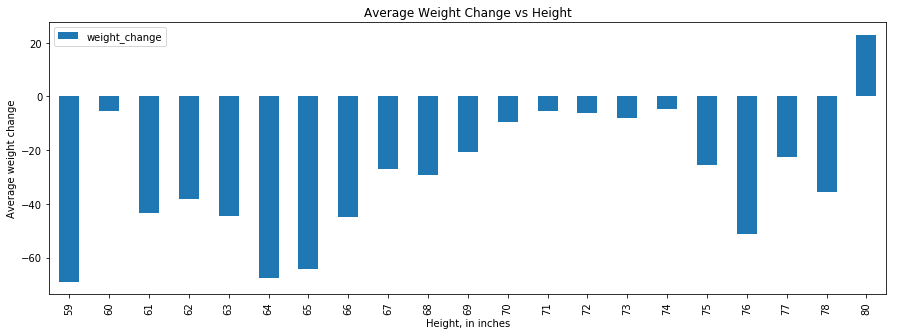

In [44]:
ax = data.groupby(['height_in']).mean().plot.bar( y='weight_change', figsize=(15,5))
ax.set(xlabel='Height, in inches', ylabel='Average weight change', title="Average Weight Change vs Height")

<p>Pictured above is the average weight change for each each represented in our data set. Note that this is from both subreddits. Interestingly enough, it seems that there's quite a lack of transformations in the 70-74 inch range, which is generally considered average height. It looks like a lot of the transformations are from extreme ends of the height spectrum.</p>

<p>Now let's see how this data changes when we differentiate between the subreddits.</p>

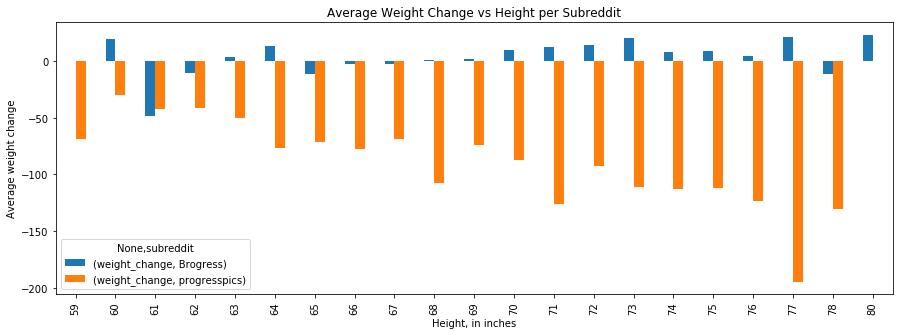

In [45]:
ax = data[['subreddit','height_in','weight_change']].groupby(['height_in','subreddit']).mean().unstack().plot.bar(figsize=(15,5))
ax.set(xlabel='Height, in inches', ylabel='Average weight change', title="Average Weight Change vs Height per Subreddit")

<p>It seems that the Brogress subreddit is a little more focused on gaining weight rather than losing it!</p>

<p>Reddit is also all about scoring content - users are able to upvote and downvote posts. A post's 'Score' is its net upvote and downvote count. So, what about score? Is there a correlation between weight change and score?</p>

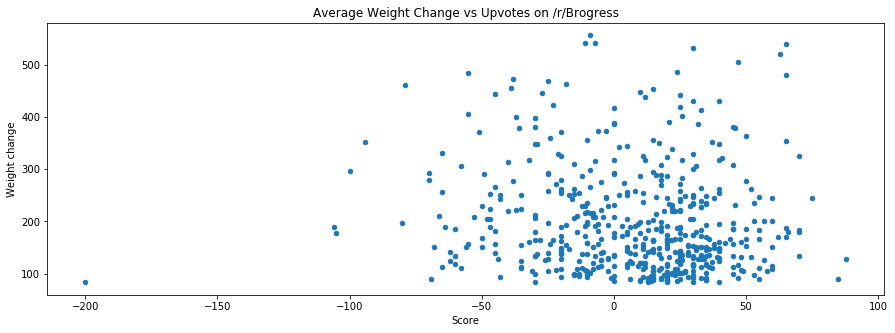

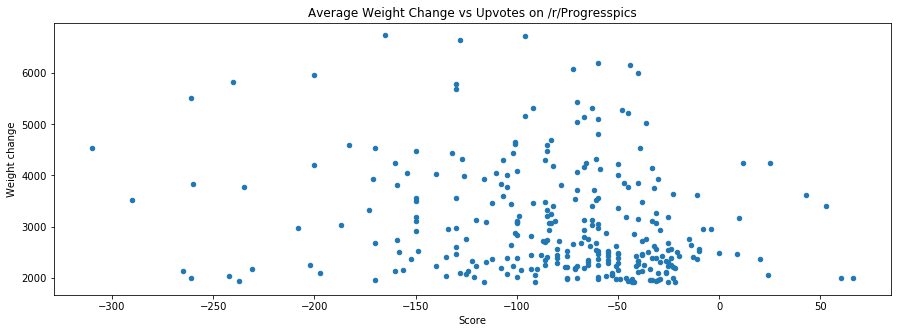

In [46]:
ax1 = data[data['subreddit'] == 'Brogress'].plot(kind='scatter', x='weight_change',y='score', figsize=(15,5))
ax2 = data[data['subreddit'] == 'progresspics'].plot(kind='scatter', x='weight_change',y='score',figsize=(15,5))
ax1.set(xlabel='Score', ylabel='Weight change', title="Average Weight Change vs Upvotes on /r/Brogress")
ax2.set(xlabel='Score', ylabel='Weight change', title="Average Weight Change vs Upvotes on /r/Progresspics")                                                     

<p>At first glance, it becomes apparant that pretty on both subreddits the score for the various posts typically cluster together. There are a few outliers on each plot, but it doesn't score vs weight change doesn't seem to scale well. For example, one might think that more weight loss or gain is impressive and might recieve more upvotes, however that does not seem to be the case.</p>

<p>Another thing these plots highlight is again that /r/brogress seems more about gaining than losing weight.</p>

<p>Let's look at the gender distribution between the subreddits in our dataset by making some pie charts.</p>

In [47]:
#groupbygender
genders = data.groupby(['gender','subreddit']).size().unstack(0)
f = genders.reset_index(0)
f

gender,subreddit,F,M
0,Brogress,20,509
1,progresspics,221,73


(-1.0651014278268724,
 1.1463467438405819,
 -1.2595358194380675,
 1.1075969437827651)

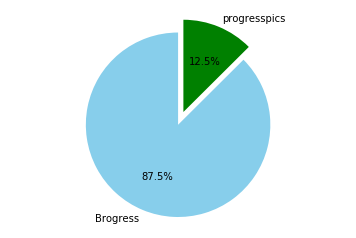

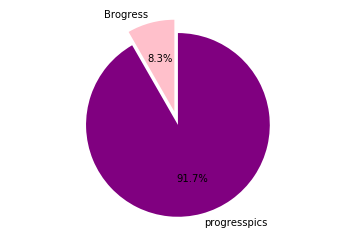

In [48]:
genders.reset_index(0)
plt.figure(1)

plt.pie(
    f['M'],
    labels=f['subreddit'],
    autopct='%1.1f%%',
    explode=( 0, 0.15),
    colors = ["skyblue","green"],
    startangle=90,
)
plt.axis('equal')
plt.figure(2)
plt.pie(
    f['F'],
    labels=f['subreddit'],
    autopct='%1.1f%%',
    explode=( 0, 0.15),
    colors = ["pink","purple"],
    startangle=90,
)
plt.axis('equal')

<p>The top blue and green pie chart shows that for all the males in our dataset, almost 88% of them posted on /r/brogress instead of /r/progresspics. The bottom plot shows that almost 92% of females in our dataset posted on /r/progresspics instead of /r/brogress. This just highlights that there is a large gap in gender between each subreddit.</p>

<p>With that being said, let's look at the minority's post scores in each subreddit. Let's plot the same plots above of weight change vs. score, but highlight the minority gender in red for each one, and see if there are any noticable trends. Does the minority gender score higher or lower in either subreddit?</p>

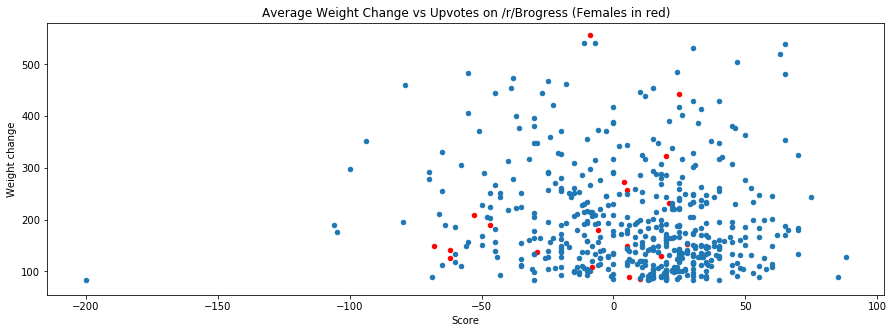

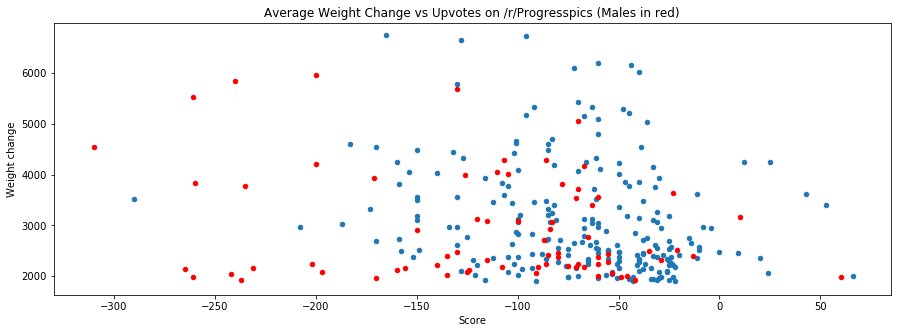

In [49]:


# plot each one
ax1 = data[(data['subreddit'] == 'Brogress') & (data['gender'] == 'F')].set_index('gender').plot(kind='scatter', x='weight_change',y='score', figsize=(15,5), color="red")
data[(data['subreddit'] == 'Brogress') & (data['gender'] == 'M')].set_index('gender').plot(kind='scatter', x='weight_change',y='score', figsize=(15,5), ax = ax1)


ax2 = data[(data['subreddit'] == 'progresspics') & (data['gender'] == 'F')].plot(kind='scatter', x='weight_change',y='score',figsize=(15,5))
ax2 = data[(data['subreddit'] == 'progresspics') & (data['gender'] == 'M')].plot(kind='scatter', x='weight_change',y='score',figsize=(15,5), color="red", ax = ax2)

ax1.set(xlabel='Score', ylabel='Weight change', title="Average Weight Change vs Upvotes on /r/Brogress (Females in red)")
ax2.set(xlabel='Score', ylabel='Weight change', title="Average Weight Change vs Upvotes on /r/Progresspics (Males in red)")                                                     

<p>There's not enough evidence to draw a conclusion on whether or not the minority scores higher in either subreddit (doesn't look like it), but one interesting thing to note is that males who lost weight posted more in /r/progresspics rather than /r/brogress.</p>

<h3>4. Classification</h3>
<i>"Bro or Pro? Let's find out."</i>

<p> Now we're going to see if we can train a __[Random Forest Classifier](https://en.wikipedia.org/wiki/Random_forest)__ that can predicate which subreddit a person would post on based on their gender, age, height and weight change.</p>
<p>Let's start by copying the dataframe.</p>

In [50]:
model = data.copy()

<p>Let's then seperate our data into training and test data, and then formally define our features. As stated above, these will be the features which will be considered when classifying.</p>

In [51]:
model['is_train'] = np.random.uniform(0, 1, len(model)) <= .70

In [52]:
features = ['gender','age','height_in','weight_change']

<p>Now let's quickly switch the gender to a number; 0 for female, and 1 for male.</p>

In [53]:
for index, row in model.iterrows():      
    if (row['gender'] == 'F'):
        model.at[index,'gender'] = 0
    elif (row['gender'] == 'M'):
        model.at[index,'gender'] = 1

<p> Now let's seperate the sets into two different datatables.</p>

In [54]:
train, test = model[model['is_train']==True], model[model['is_train']==False]

<p>Now let's generate numerics results for our classifications. 0 for progresspics, 1 for brogress.</p>

In [55]:
y = pd.factorize(train['subreddit'])[0]

<p>Now let's make it and train it!</p>

In [56]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)

In [57]:
clf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

<p>Now let's put out test data to use and see how accurate our model is at prediciting.</p>
<p>We're going to run a 10-fold cross-validation on our testing data.</p>

In [58]:
x = pd.factorize(test['subreddit'])[0]
scores = cross_val_score(clf, test[features], x, cv=10)
scores.mean()

0.91004611330698282

<p>Hey, that isn't that bad! Let's do a quick example just to clarify what is happening.</p>

In [59]:
stats = [1, 29, 69, -50]

These stats are for a male who is 29 years old, 69 inches tall and has lost 15 pounds. Which subreddit do you think our classifier will think he'll post in?

In [60]:
clf.predict([[1, 29, 69, -15]])[0]

1

<p>Our classifier says /r/progresspics. Neato.</p>
<p>Let's quickly breakdown what our classifier thought was important when classifiying:</p>

In [61]:
list(zip(train[features], clf.feature_importances_))

[('gender', 0.4818977716524005),
 ('age', 0.079080789984870711),
 ('height_in', 0.070160055183241046),
 ('weight_change', 0.36886138317948769)]

<h3>4. Wrap up</h3>
<i>"That's a (healthy & low calorie wrap)" - /r/progresspics</i>

<p>So, what have we learned today? We learned quite a bit about scraping and tidying data from a popular website. We got a chance to play with the data and make some interesting visualizations. We also found out that it seems the 'bro' in /r/brogress is no misnomer - a lot of males who seem to want to put on weight, and that just because a transformation is extreme dosen't mean it will net you a lot of upvotes. And lastly, we trained our own classifier with our data to see if we could predict which subreddit a user would post their transformation in (and it turned out great!).</p>